# SARIMA-GARCH-CNN-BiLSTM model for forecasting future stock prices

## Team Members:
1. Ahmik Virani - ES22BTECH11001
2. Prajjwal Prashant Lade - ES22BTECH11027
3. Dhawal Gupta - ES22BTECH11015
4. Gaurav Choudekar - CS22BTECH11015
5. Shreyas Wankhede - AI21BTECH11028

In [1]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 11.8 MB/s eta 0:00:00


In [1]:
# Import the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import Bidirectional, LSTM, Dropout, Dense, Input

from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.style.use('fivethirtyeight')

In [2]:
# Load the stock data
data = pd.read_csv('SBI_Historical_Data.csv')
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)
data = data.sort_values('Date').reset_index(drop=True)
close_prices = data['Close']

# Compute the returns
returns = 100 * close_prices.pct_change().dropna()

data['returns'] = returns

In [3]:
# Compute the split index for train test split later
split_idx = int(len(returns) * 0.9)

In [4]:
# Index by date

dataset = data
dataset = dataset.set_index('Date')
dataset = dataset.sort_index()

In [5]:
# We are concerned only with the closing stock price

series = dataset['Close']

In [6]:
def apply_sarima(series):
    model = SARIMAX(series, order=(1,1,1), seasonal_order=(1,1,1,12))
    sarima_result = model.fit(disp=False)
    forecast = sarima_result.fittedvalues
    residuals = series - forecast
    return forecast, residuals

In [7]:
def apply_garch(residuals):
    model = arch_model(residuals, vol='GARCH', p=1, q=1)
    garch_result = model.fit(disp='off')
    garch_forecast = garch_result.conditional_volatility
    remaining_residuals = residuals - garch_forecast
    return garch_forecast, remaining_residuals

In [8]:
def create_sequences(data, window=20):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i])
        y.append(data[i])
    return np.array(X), np.array(y)

In [9]:
sarima_pred, sarima_res = apply_sarima(series)
garch_pred, garch_res = apply_garch(sarima_res)

/Users/ahmikvirani/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/ahmikvirani/.pyenv/versions/3.11.5/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [10]:
# Ensure the garch residuals are scaled properly

scaler = MinMaxScaler()
garch_res_scaled = scaler.fit_transform(np.array(garch_res).reshape(-1, 1)).flatten()

In [11]:
# Since we need the deep learning model to learn the trends in the garch residulas, ensure to scale them properly

window_size = 20
X, y = create_sequences(garch_res_scaled, window=window_size)
X = X.reshape((X.shape[0], 4, 5, 1))

In [12]:
# Making the model as per the given paper instructions

model = Sequential()
model.add(Input(shape=(4, 5, 1)))
model.add(TimeDistributed(Conv1D(filters=256, kernel_size=2, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))
model.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation='relu')))
model.add(TimeDistributed(MaxPooling1D(pool_size=2, padding='same')))
model.add(TimeDistributed(Flatten()))
model.add(Bidirectional(LSTM(128, activation='relu', return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation='relu')))
model.add(Dropout(0.5))
model.add(Dense(1, activation='linear'))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed                │ (None, 4, 4, 256)      │           768 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 4, 2, 256)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 4, 1, 128)      │        65,664 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 4, 1, 128)      │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 4, 128)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 4, 256)         │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │       122,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 452,501 (1.73 MB)

 Trainable params: 452,501 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Split the data into training and testing set
X_train = X[:split_idx]
X_test = X[split_idx:]

y_train = y[:split_idx]
y_test = y[split_idx:]

In [14]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1561
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0545
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0523
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0477
Epoch 5/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0413
Epoch 6/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0365
Epoch 7/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0326
Epoch 8/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0300
Epoch 9/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0269
Epoch 10/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0240


In [15]:
# Make predictions

cnn_bilstm_pred = model.predict(X_test).flatten()
cnn_bilstm_pred = scaler.inverse_transform(cnn_bilstm_pred.reshape(-1, 1)).flatten()

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step


In [16]:
# Combine all the approaches to get the final answer

final_pred = sarima_pred[-len(cnn_bilstm_pred):] + garch_pred[-len(cnn_bilstm_pred):] + cnn_bilstm_pred

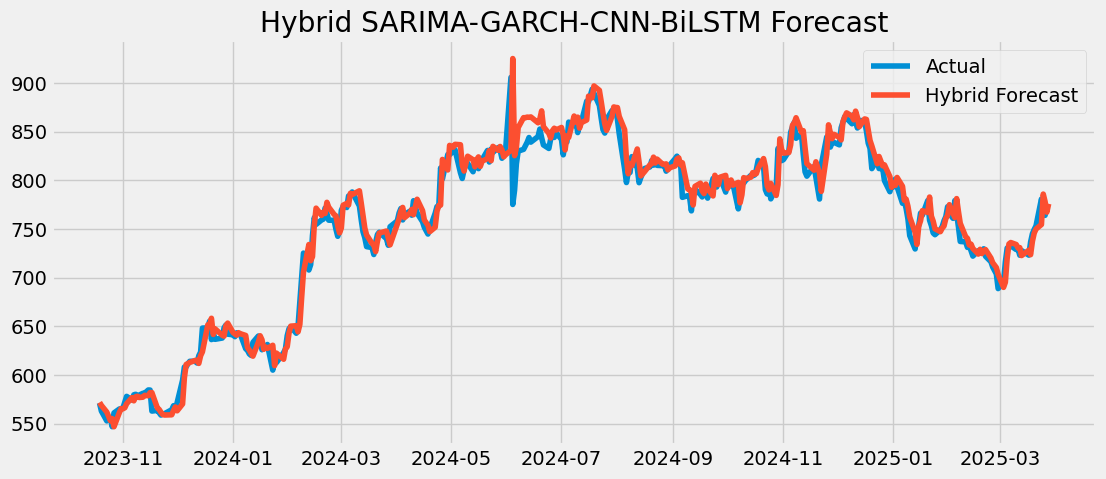

In [17]:
# Plot the figure

plt.figure(figsize=(12, 5))
plt.plot(series[-len(final_pred):], label="Actual")
plt.plot(final_pred, label="Hybrid Forecast")
plt.legend()
plt.title("Hybrid SARIMA-GARCH-CNN-BiLSTM Forecast")
plt.show()